In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


## 4. ROI 추출

In [3]:
data = pd.read_csv('골밀도 데이터/total_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1698,8255049,2007-08-03,F,1,9.969863,129.5,26.9,16.1,2017-01-09,2017-07-20,9.75,9.75,NaN,1.jpg,9.750
1,1897,8537405,2008-08-22,F,1,9.989041,132.0,31.0,17.8,2018-02-28,2018-08-16,10.50,11.00,NaN,2.jpg,10.750
2,1422,7942635,2005-01-19,F,1,10.008219,136.4,33.2,17.9,2015-01-20,2015-01-20,11.00,11.25,NaN,3.jpg,11.125
3,1475,7995857,2005-02-09,F,1,10.049315,133.5,31.2,17.6,2015-02-25,2015-02-25,10.00,10.25,NaN,4.jpg,10.125
4,1888,8520261,2008-09-11,F,1,10.060274,130.6,23.7,13.9,2018-10-01,2018-10-01,10.00,9.75,NaN,5.jpg,9.875


### 샘플이미지 ROI 추출
+ 샘플 이미지 로드 및 이진화

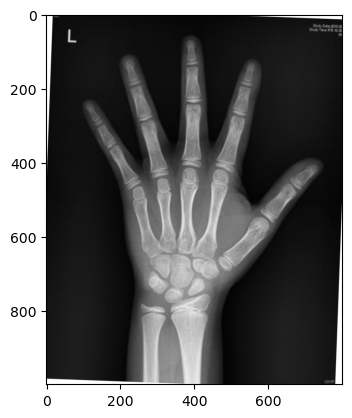

In [5]:
img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[11], cv2.IMREAD_GRAYSCALE)
plt.imshow(img0, 'gray')

In [6]:
# 이미지 thresholding
r_img = np.copy(img0)
height, width = img0.shape
img = img0[(int)(height*0.05):(int)(height*0.95),(int)(width*0.05):(int)(width*0.95)]
ret, img = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)

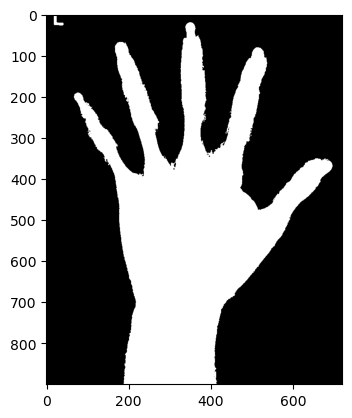

In [7]:
plt.imshow(img, 'gray')

In [5]:
# 이미지 thresholding
r_img = np.copy(img0)
height, width = img0.shape
img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

# 이미지 contouring
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_cnt = max(contours, key = cv2.contourArea)
mask = np.zeros(img.shape, dtype= np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

오목한 좌표와 볼록한 좌표 구하기

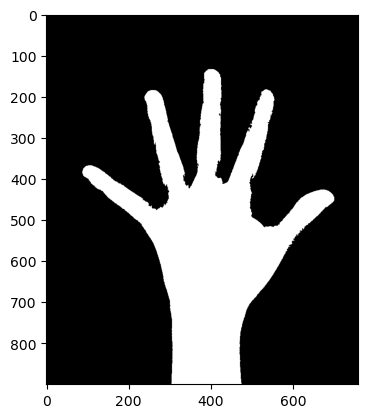

In [6]:
plt.imshow(mask, 'gray')

In [7]:
#좌표 저장공간 설정(첫번째 공간에는 무게중심점, 두번째 공간에는 start점, 세번째에는 far점) 
dots = [[],[],[]]

# 이진화 이미지에서 1차 모멘트 구하기
M = cv2.moments(max_cnt) 
center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
dots[0].append(center)

# 볼록한 점 구하기
hull = cv2.convexHull(max_cnt, returnPoints= False)
hull1 = cv2.convexHull(max_cnt)
hull1.shape

(17, 1, 2)

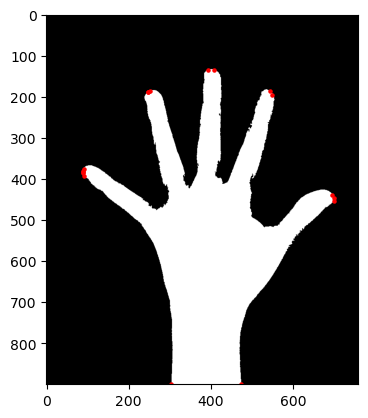

In [8]:
plt.imshow(mask, 'gray')
for grid in hull1:
    x, y = grid[0]
    plt.scatter([x], [y], c = 'red', marker = 'o', s = 5)

plt.show()

In [9]:
# 오목한 지점 구하기
defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환
defects[0,0]

array([    0,   289,   133, 65746], dtype=int32)

In [10]:
# 거리를 저장할 수 있는 공간 생성
di = []

for index in range(defects.shape[0]):
    # 시작점, 끝점, far 점, 거리 할당
    sp, ep, fp, distance = defects[index, 0]
    
    # 거리 저장
    di.append(distance)
    
# 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting
di = np.array(di)
s_di = np.sort(di)[::-1]

far_xrange = []
far_yrange = []
start_xrange = []
start_yrange = []
end_xrange = []
end_yrange = []

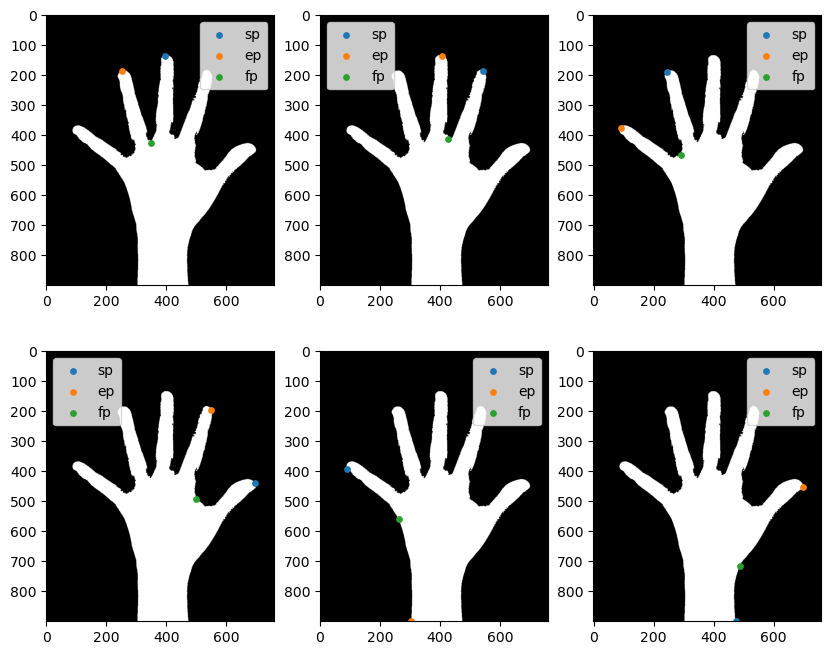

In [11]:
fig, ax = plt.subplots(2,3, figsize = (10, 8))
for i, dis in enumerate(list(s_di[:6])):
    index = np.where(di == dis)[0][0]
    
    sp, ep, fp, _ = defects[index, 0]
    
    far_xrange.append(max_cnt[fp][0][0])
    far_yrange.append(max_cnt[fp][0][1])
    start_xrange.append(max_cnt[sp][0][0])
    start_yrange.append(max_cnt[sp][0][1])
    end_xrange.append(max_cnt[ep][0][0])
    end_yrange.append(max_cnt[ep][0][1])
    
    for point in [sp, ep, fp]:
        ax[i//3, i%3].imshow(mask, 'gray')
        ax[i//3, i%3].scatter(max_cnt[point][0][0], max_cnt[point][0][1], s = 15)
        ax[i//3, i%3].legend(['sp', 'ep', 'fp'])
        
plt.show()

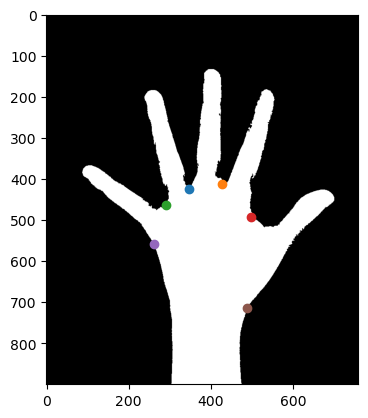

In [12]:
plt.imshow(mask, 'gray')
for i in range(len(far_xrange)):
    plt.scatter(far_xrange[i], far_yrange[i])

### 손목뼈 좌표 추출

손목 관절 roi 좌표 


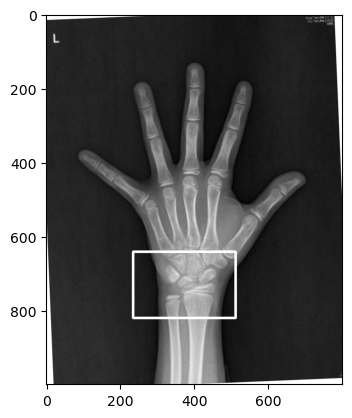

In [13]:
#손목뼈 ROI
carpus_sp = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
carpus_ep = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))

carpus=cv2.rectangle(np.copy(img0), carpus_sp, carpus_ep,[255,255,255],5)

#ROI 확인
print("손목 관절 roi 좌표 ")
plt.imshow(carpus,"gray")

### 손목뼈 위쪽 관절 추출

가운데 4개 관절 roi 좌표


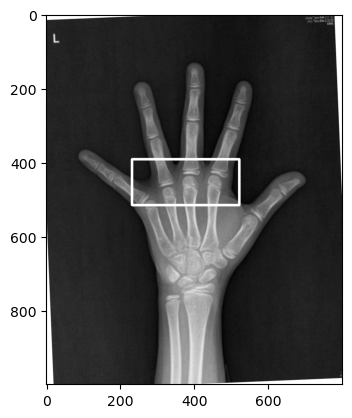

In [14]:
#손목뼈 위쪽에 있는 관절 4개를 추출

four_sp = ((int)(min(far_xrange[0:4])*0.80),int(min(far_yrange[0:4])*0.95))
four_ep = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

finger4=cv2.rectangle(np.copy(img0),four_sp, four_ep,[255,255,255],5)

#ROI 확인
print("가운데 4개 관절 roi 좌표")
plt.imshow(finger4,"gray")

### 중지 좌표 추출

In [15]:
#중지 끝 좌표 구하기
for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break

중지 roi 좌표


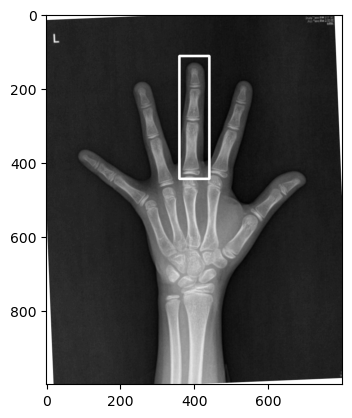

In [16]:
#중지 ROI 추출
sub = min(abs(first_255_x_point - far_xrange[0]), abs(first_255_x_point - far_xrange[1]))
middle_finger_sp = (int((first_255_x_point - sub*1.5)), int(first_255_y_point*0.85))
middle_finger_ep = (int((first_255_x_point + sub*1.5)), int(far_yrange[0]*1.05))

finger3=cv2.rectangle(np.copy(img0),middle_finger_sp, middle_finger_ep, [255,255,255], 5)

#ROI 확인
print("중지 roi 좌표")
plt.imshow(finger3,"gray")

### 새끼손가락 좌표 추출

새끼손가락 roi 좌표


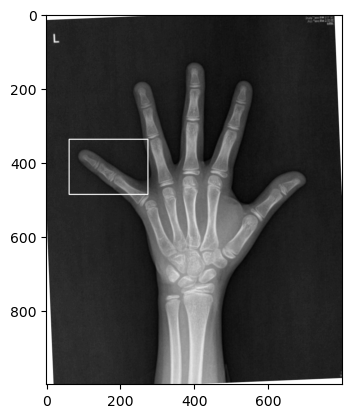

In [17]:
# #새끼손가락 좌표
little_finger_sp = (int(min(end_xrange)*0.7), int(end_yrange[end_xrange.index(min(end_xrange[0:4]))]*0.9))
little_finger_ep = (int(min(far_xrange[0:4])*0.95), int(far_yrange[far_xrange.index(min(far_xrange[0:4]))]*1.05))

finger5=cv2.rectangle(np.copy(img0),little_finger_sp, little_finger_ep,[255,255,255],2)

#ROI 확인
print("새끼손가락 roi 좌표")
plt.imshow(finger5,"gray")

### 엄지손가락 좌표 추출

엄지손가락 roi 좌표


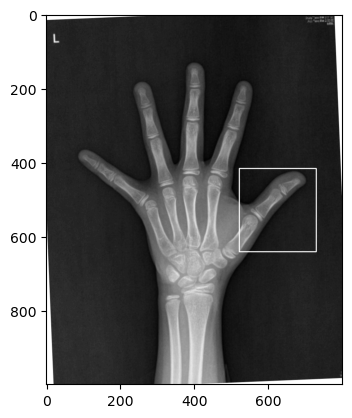

In [18]:
#엄지손가락 좌표
thumb_sp = (int(max(far_xrange[0:4])*1.05), int(start_yrange[start_xrange.index(max(start_xrange))]*0.95))
thumb_ep = (int(max(start_xrange)*1.05), int(max(far_yrange)*0.9))
# int(far_yrange[far_xrange.index(max(far_xrange[0:4]))]*1.1)

finger1=cv2.rectangle(np.copy(img0),thumb_sp, thumb_ep,[255,255,255],2)

#ROI 확인
print("엄지손가락 roi 좌표")
plt.imshow(finger1,"gray")

### Cropping


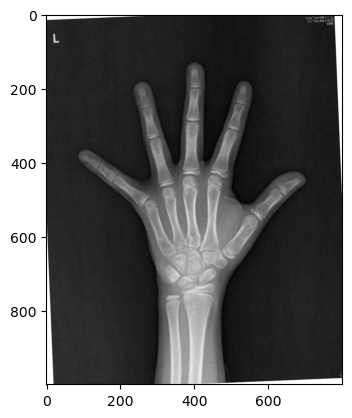

In [19]:
plt.imshow(img0, 'gray')

In [45]:
def optimize_img(r1,r2,r3,r4):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for img in [r1,r2,r3,r4]:
        if img is not None:
            # resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            # _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            
            target_length = 500
            (original_height, original_width) = clahed_img.shape
            # 가로세로 비율을 유지하면서 긴 부분을 target_length로 조정합니다.
            if original_width > original_height:
                # 가로가 길 경우
                new_width = target_length
                new_height = int((new_width / original_width) * original_height)
            else:
                # 세로가 길 경우
                new_height = target_length
                new_width = int((new_height / original_height) * original_width)

            # 이미지 크기 조정
            resized_image = cv2.resize(clahed_img, (new_width, new_height))
            
            # 최종 이미지 크기
            target_size = 600
            old_size = resized_image.shape

            # 새로운 이미지 생성 (검은색 배경)
            new_image = np.zeros((target_size, target_size), dtype=np.uint8)

            # 이미지 중앙에 배치하기 위한 좌표 계산
            start_x = (target_size - old_size[1]) // 2
            start_y = (target_size - old_size[0]) // 2

            # 원본 이미지를 중앙에 배치
            new_image[start_y:start_y+old_size[0], start_x:start_x+old_size[1]] = resized_image
            
            tmp_binary_img.append(new_image)
                
    return np.array(tmp_binary_img)

In [46]:
def crop_img(img, roi_1, roi_2, roi_3, roi_4):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]]
    cropped_roi_4_img = img[roi_4[0][1]:roi_4[1][1],roi_4[0][0]:roi_4[1][0]]

    optimzed_imgs = optimize_img(cropped_roi_1_img, cropped_roi_2_img, cropped_roi_3_img, cropped_roi_4_img)
    return optimzed_imgs

In [49]:
optimized_imgs = crop_img(img0,(carpus_sp,carpus_ep), (four_sp, four_ep), 
                          (middle_finger_sp,middle_finger_ep), (thumb_sp, thumb_ep))

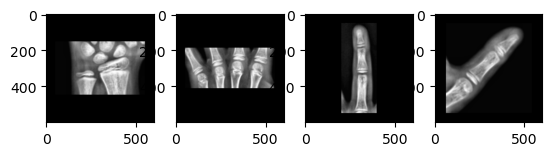

In [54]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(optimized_imgs[i], 'gray')

In [48]:
# data augmentation - rotation
aug_rot_img = []
angle = np.random.randint(0, 90)
for i in range(4):
    crop_image = optimized_imgs[i].copy()
    # 이미지 중심을 계산
    center = (crop_image.shape[1] // 2, crop_image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 회전된 이미지의 경계가 잘리지 않도록 출력 이미지의 크기 조정
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])

    # 새로운 경계 차원 계산
    new_width = int((crop_image.shape[0] * sin) + (crop_image.shape[1] * cos))
    new_height = int((crop_image.shape[0] * cos) + (crop_image.shape[1] * sin))

    # 변환 행렬의 이동 부분 조정
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]

    # 회전된 이미지 얻기
    rotated_img = cv2.warpAffine(crop_image, rotation_matrix, (new_width, new_height))
    rotated_img = cv2.resize(rotated_img, (600, 600))
    aug_rot_img.append(rotated_img)
    
row1 = np.vstack((aug_rot_img[0], aug_rot_img[1]))
row2 = np.vstack((aug_rot_img[2], aug_rot_img[3]))

combined_image_rot = np.hstack((row1, row2))
combined_image_rot = cv2.resize(combined_image_rot, (256, 256))

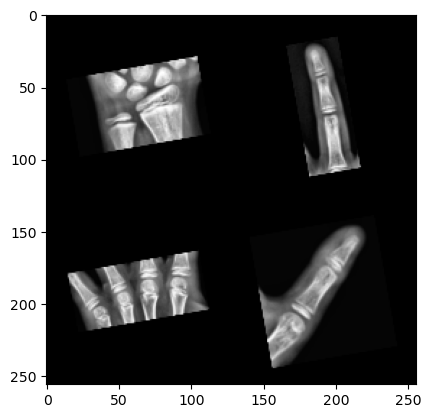

In [9]:
plt.imshow(combined_image_rot, 'gray')

In [118]:
aug_noise_img = []
sigma = np.random.randint(0, 90)
for crop_image in optimized_imgs:
    row, col = crop_image.shape
    
    # 노이즈 강도 조정
    gaussian = np.random.normal(0, sigma, (row, col))
    
    # 노이즈 추가된 이미지 얻기
    noisy_image = np.clip(crop_image + gaussian, 0, 255)
    aug_noise_img.append(noisy_image)

In [119]:
row1 = np.vstack((aug_noise_img[0], aug_noise_img[1]))
row2 = np.vstack((aug_noise_img[2], aug_noise_img[3]))

In [120]:
combined_image_noise = np.hstack((row1, row2))
combined_image_noise = cv2.resize(combined_image_noise, (256, 256))

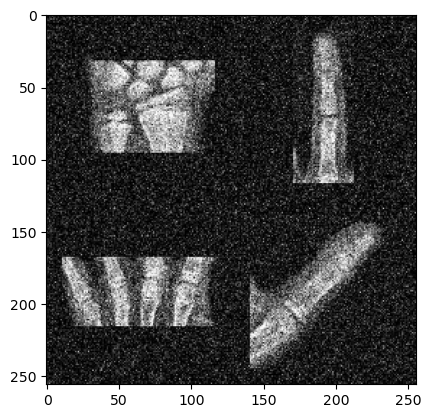

In [123]:
plt.imshow(combined_image_noise, 'gray')

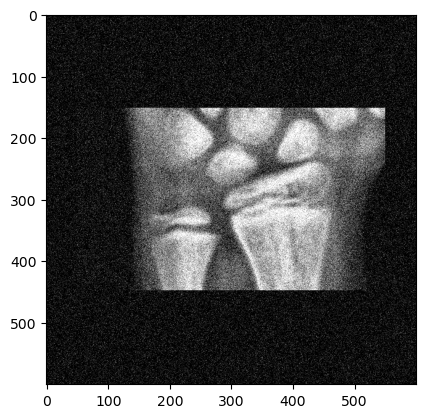

In [109]:
# data augmentation - add noise
sigma = np.random.randint(10, 50)
row, col = optimized_imgs[0].shape
gaussian = np.random.normal(0, sigma, (row, col))
noisy_image = np.clip(optimized_imgs[0] + gaussian, 0, 255).astype(np.uint32)
plt.imshow(noisy_image, 'gray')

### 전체 데이터에 대해 수행

In [50]:
img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[10], cv2.IMREAD_GRAYSCALE)

# 이미지 thresholding
r_img = np.copy(img0)
height, width = img0.shape
img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

# 이미지 contouring
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key = cv2.contourArea)
mask = np.zeros(img.shape, dtype= np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

# 볼록한 점 구하기
hull = cv2.convexHull(max_cnt, returnPoints= False)
hull1 = cv2.convexHull(max_cnt)

# 오목한 지점 구하기
defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환

# 거리를 저장할 수 있는 공간 생성
di = []

for index in range(defects.shape[0]):
    # 시작점, 끝점, far 점, 거리 할당
    sp, ep, fp, distance = defects[index, 0]
    
    # 거리 저장
    di.append(distance)

far_xrange = []
far_yrange = []
start_xrange = []
start_yrange = []

# 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
di = np.array(di)
s_di = np.sort(di)[::-1]

# 내림차순된 거리들을 6개만 뽑아내기 위해 slice
for i in list(s_di[:6]):
    index = np.where(di == i)[0][0]
    
    sp, ep, fp, _ = defects[index, 0]
    
    far_xrange.append(max_cnt[fp][0][0])
    far_yrange.append(max_cnt[fp][0][1])
    
    start_xrange.append(max_cnt[sp][0][0])
    start_yrange.append(max_cnt[sp][0][1])
    

#손목뼈 ROI
carpus_sp = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
carpus_ep = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))

#손목뼈 위쪽에 있는 관절 4개를 추출
four_sp = ((int)(min(far_xrange[0:4])*0.70),int(min(far_yrange[0:4])*0.95))
four_ep = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

#중지 ROI 추출
#중지 끝 좌표 구하기
for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break
    
## 중지 끝 좌표에서 처음 오목한 곳의 x 좌표를 뺀 간격만큼
sub = min(abs(first_255_x_point - far_xrange[0]), abs(first_255_x_point - far_xrange[1]))
middle_finger_sp = (int((first_255_x_point - sub*1.5)), int(first_255_y_point*0.85))
middle_finger_ep = (int((first_255_x_point + sub*1.5)), int(far_yrange[0]*1.05))

# 새끼손가락 좌표
# little_finger_sp = (int(min(end_xrange)*0.7), int(end_yrange[end_xrange.index(min(end_xrange[0:4]))]*0.9))
# little_finger_ep = (int(min(far_xrange[0:4])*0.95), int(far_yrange[far_xrange.index(min(far_xrange[0:4]))]*1.05))


#엄지손가락 좌표
thumb_sp = (int(max(far_xrange[0:4])*1.05), int(start_yrange[start_xrange.index(max(start_xrange))]*0.95))
thumb_ep = (int(max(start_xrange)*1.05), int(max(far_yrange)*0.9))

optimized_imgs = crop_img(img0,(carpus_sp,carpus_ep), (four_sp, four_ep), 
                          (middle_finger_sp,middle_finger_ep), (thumb_sp, thumb_ep))

In [51]:
optimized_imgs.shape

(4, 600, 600)

In [52]:
row1 = np.vstack((optimized_imgs[0], optimized_imgs[1]))
row2 = np.vstack((optimized_imgs[2], optimized_imgs[3]))

combined_image = np.hstack((row1, row2))
print(combined_image.shape)

combined_image1 = cv2.resize(combined_image, (256, 256))
print(combined_image1.shape)

(1200, 1200)
(256, 256)


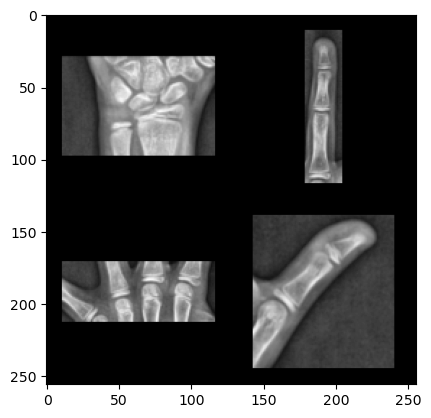

In [53]:
plt.imshow(combined_image1, 'gray')

In [54]:
X_data = []
y_data = []
for k in range(len(data)):
    if k == 354 or k == 355 or k == 916:
        continue
    img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[k], cv2.IMREAD_GRAYSCALE)

    # 이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

    # 이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key = cv2.contourArea)
    mask = np.zeros(img.shape, dtype= np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

    # 볼록한 점 구하기
    hull = cv2.convexHull(max_cnt, returnPoints= False)
    hull1 = cv2.convexHull(max_cnt)

    # 오목한 지점 구하기
    defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환

    # 거리를 저장할 수 있는 공간 생성
    di = []

    for index in range(defects.shape[0]):
        # 시작점, 끝점, far 점, 거리 할당
        sp, ep, fp, distance = defects[index, 0]
        
        # 거리 저장
        di.append(distance)

    far_xrange = []
    far_yrange = []
    start_xrange = []
    start_yrange = []

    # 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
    di = np.array(di)
    s_di = np.sort(di)[::-1]

    # 내림차순된 거리들을 6개만 뽑아내기 위해 slice
    for i in list(s_di[:6]):
        index = np.where(di == i)[0][0]
        
        sp, ep, fp, _ = defects[index, 0]
        
        far_xrange.append(max_cnt[fp][0][0])
        far_yrange.append(max_cnt[fp][0][1])
        
        start_xrange.append(max_cnt[sp][0][0])
        start_yrange.append(max_cnt[sp][0][1])
        

    #손목뼈 ROI
    carpus_sp = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
    carpus_ep = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))

    #손목뼈 위쪽에 있는 관절 4개를 추출
    four_sp = ((int)(min(far_xrange[0:4])*0.70),int(min(far_yrange[0:4])*0.95))
    four_ep = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

    #중지 ROI 추출
    #중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
        
    ## 중지 끝 좌표에서 처음 오목한 곳의 x 좌표를 뺀 간격만큼
    sub = min(abs(first_255_x_point - far_xrange[0]), abs(first_255_x_point - far_xrange[1]))
    middle_finger_sp = (int((first_255_x_point - sub*1.5)), int(first_255_y_point*0.85))
    middle_finger_ep = (int((first_255_x_point + sub*1.5)), int(far_yrange[0]*1.05))

    # # 새끼손가락 좌표
    # little_finger_sp = (int(min(end_xrange)*0.7), int(end_yrange[end_xrange.index(min(end_xrange[0:4]))]*0.9))
    # little_finger_ep = (int(min(far_xrange[0:4])*0.95), int(far_yrange[far_xrange.index(min(far_xrange[0:4]))]*1.05))

    #엄지손가락 좌표
    thumb_sp = (int(max(far_xrange[0:4])*1.05), int(start_yrange[start_xrange.index(max(start_xrange))]*0.95))
    thumb_ep = (int(max(start_xrange)*1.05), int(max(far_yrange)*0.9))
    
    optimized_imgs = crop_img(img0,(carpus_sp,carpus_ep), (four_sp, four_ep), 
                              (middle_finger_sp,middle_finger_ep), (thumb_sp, thumb_ep))
    
    row1 = np.vstack((optimized_imgs[0], optimized_imgs[1]))
    row2 = np.vstack((optimized_imgs[2], optimized_imgs[3]))

    combined_image = np.hstack((row1, row2))
    combined_image = cv2.resize(combined_image, (256, 256))

    X_data.append(combined_image)
    y_data.append(data.boneage[k])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [55]:
np.array(X_data).shape

(1234, 256, 256)

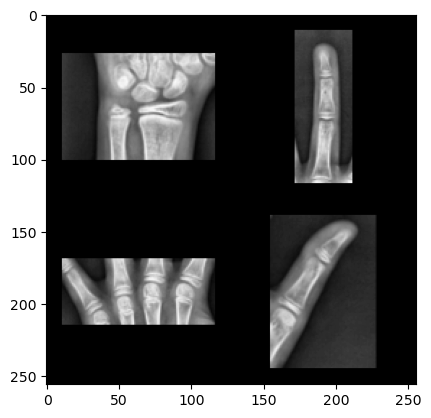

In [56]:
plt.imshow(X_data[19], 'gray')